# Topic Modeling on a Small Scientific Corpus

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
%cd "/content/drive/MyDrive/Clustering_USGS"

/content/drive/MyDrive/Clustering_USGS


In [79]:
%%capture
!pip install umap-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import gensim
from gensim import corpora
from gensim import models

import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [80]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [81]:
df = pd.read_csv('abstracts.csv')

In [82]:
df_test = pd.read_csv('abstracts_test.csv')
df_test = df_test[['Title', 'Text']]
df_test = df_test.dropna()

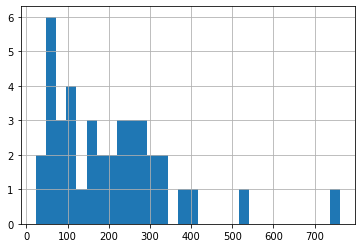

In [83]:
def word_count(text):
    return len(str(text).strip().split(" "))
    
temp_df = df.copy()
temp_df['word_count'] = temp_df['Text'].apply(word_count)
pd.Series(temp_df.word_count.values).hist(bins = 30)

### Preprocess Data for BoW Models

In [84]:
nltk.download('stopwords')
sw = stopwords.words('english')
sw = sw + ['model']
sw = set(sw)

def preprocess_data(documents):
  tokenizer = RegexpTokenizer(r'\w+')
  stemmer = SnowballStemmer("english")
  texts = []
  for i in documents:
        lower_text = i.lower()
        # tokenize
        tokens = tokenizer.tokenize(lower_text)
        # remove stopwords
        stopped_tokens = [i for i in tokens if not i in sw]
        # stem words
        stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
        # append list
        texts.append(stemmed_tokens)
  return texts


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
document_list = df.Text.values
tokens = preprocess_data(document_list)

In [86]:
test_document_list = df_test.Text.values
test_tokens = preprocess_data(test_document_list)

In [87]:
dictionary = corpora.Dictionary(tokens)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in tokens]

In [88]:
test_BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in test_tokens]

In [89]:
# # Human-readable dictionary
# id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
# print(id_words)

In [90]:
tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

In [91]:
test_corpus_tfidf = tfidf[test_BoW_corpus]

In [92]:
# # View td-idf
# for doc in tfidf[BoW_corpus]:
#    print([[dictionary[id], round(freq, 2)] for id, freq in doc])

### Preprocess Text for BERT-type Embeddings

In [93]:
document_list = df.Text.values

Yep. That's it!

### Get Common Words in Abstracts for Later Analysis

In [94]:
import collections

df['Common5Words'] = [0]*len(df)
for i in range(len(tokens)):
  elements_count = collections.Counter(tokens[i])
  most_comm = elements_count.most_common(5)
  Common5Words = []
  for key, value in most_comm:
    Common5Words.append(key)
    # print(f"{key}: {value}")
  df['Common5Words'].iloc[i] = Common5Words
dataset = df.copy()
dataset = dataset[['Title', 'Common5Words']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
df_test['Common5Words'] = [0]*len(df_test)
for i in range(len(test_tokens)):
  elements_count = collections.Counter(test_tokens[i])
  most_comm = elements_count.most_common(5)
  Common5Words = []
  for key, value in most_comm:
    Common5Words.append(key)
    # print(f"{key}: {value}")
  df_test['Common5Words'].iloc[i] = Common5Words

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Number of Clusters = 9
I could get rid of this analysis or show how ineffective it is in determining the number of clusters.  Although the analysis show 3 topics are sufficient, we know that there are more than 3 topics in the abstract.

In [96]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = models.LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [97]:
def plot_graph(dictionary, doc_term_matrix, doc_clean, start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("U-mass Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

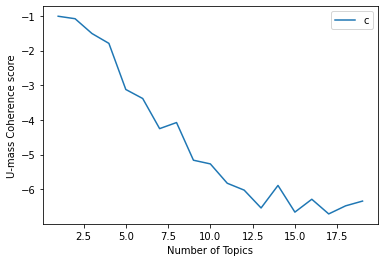

In [98]:
start,stop,step = 1,20,1
plot_graph(dictionary, BoW_corpus, tokens, start, stop, step)

In [99]:
no_clusters = 9 #Not effective for selecting number of clusers. Varies with each run: 4, 7, 9, 11, etc.

## Latent Semantic Analysis (LSA/LSI)

In [100]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=no_clusters)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]
test_corpus_lsi = lsi_model[test_corpus_tfidf]

In [101]:
# lsi_model.print_topics(9)

In [102]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: abs(x[1]), reverse = True) 
    return tup 

In [103]:
cluster_lsa = []
for i in range(len(corpus_lsi)):
  x = lsi_model[corpus_lsi[i]]
  x = Sort_Tuple(x)
  cluster_lsa.append(x[0][0])
dataset['LSA_Topic'] = cluster_lsa
dataset["LSA_Topic"] = pd.to_numeric(dataset["LSA_Topic"])

In [104]:
# dic1 = {0: 'transport_structur_flow_ground',
#     1: 'feq_structur_unsteadi_stream',
#     2: 'water_balance_transport_watersh',
#     3: 'transport_rainfall_veget_balance',
#     4: 'hydraul_modflow_veget',
#     5: 'wave_reef_ocean_flood',
#     6: 'veget_month_tool_reservoir',
#     7: 'watersh_cblcm_land_contam',
#     8: 'reservoir_veget_balanc'}
# dataset.replace({"LSA_Topic": dic1},inplace=True)

In [105]:
# for doc, as_text in zip(corpus_lsi, document_list):
#     print(doc, as_text)

#### Train Set LSA Results

##### LSA Training Coherence Score -10.4

In [106]:
cm = models.CoherenceModel(model= lsi_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
lsa_score = cm.get_coherence()
lsa_score

-11.24152838372912

##### LSA Training Silhouette Score 0.11


In [107]:
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
score = metrics.silhouette_score(X, cluster_lsa)
score

-0.06475219630877946

#### Test Set LSA Results
We transform the training corpus with the LSA model; however, once the transformation model has been initialized it can be used on any corpus provided it comes from the same vector space. 

In [108]:
test_cluster_lsa = []
for i in range(len(test_corpus_lsi)):
  x = lsi_model[test_corpus_lsi[i]]
  x = Sort_Tuple(x)
  test_cluster_lsa.append(x[0][0])
df_test['LSA_Topic'] = test_cluster_lsa
df_test["LSA_Topic"] = pd.to_numeric(df_test["LSA_Topic"])

##### LSA Testing Coherence Score n/a

In [109]:
# cm2 = models.CoherenceModel(model= lsi_model, corpus = test_BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
# lsa_score = cm2.get_coherence()
# lsa_score

# ZeroDivisionError: float division by zero

##### LSA Testing Silhouette Score 0.05

In [110]:
X = np.array([[tup[1] for tup in arr] for arr in test_corpus_lsi])
score = metrics.silhouette_score(X, test_cluster_lsa)
score

0.10786842269570387

## Latent Dirichlet Allocation (LDA)

In [111]:
%%capture
lda_model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=no_clusters, iterations=100)

In [112]:
corpus_lda = lda_model[corpus_tfidf]

In [113]:
# lda_model.print_topics(9)

In [114]:
cluster_lda = []
for i in range(len(corpus_lda)):
  x = lda_model[corpus_lda[i]]
  x = Sort_Tuple(x)
  cluster_lda.append(x[0][0])
dataset['LDA_Topic'] = cluster_lda

In [115]:
# dic2 = {0: 'structur_flow_record_conduct',
#       1: 'reef_migrat_flodd_dispers',
#       2: 'subduct_erupt_ash_feq_volcan',
#       3: 'subduc_structur_map_watersh',
#       4: 'cblcm_veget_land_submers',
#       5: 'scoops3d_dem_site_goal_statement',
#       6: 'reservoir_veget_keyword_modul',
#       7: 'threshold_rainfal_speci_precip',
#       8: 'psd_perman_channel_network_streamflow'}
# dataset.replace({"LDA_Topic": dic2}, inplace=True)

#### Train Set LDA Results

##### LDA Training Coherence Score -12.2

In [116]:
cm = models.CoherenceModel(model= lda_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
lda_score = cm.get_coherence()
lda_score

-13.748435167814588

##### LDA Training Silhouette Score -0.13

In [117]:
# LDA_score = metrics.silhouette_score(X, cluster_lda)
# LDA_score

X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
LDA_score = metrics.silhouette_score(X, cluster_lsa)
LDA_score

-0.06475219630877946

##### pyLDAvis for Training

In [118]:
%%capture
!pip install pyLDAvis==3.3.1
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [119]:
vis_data1 = gensimvis.prepare(lda_model, BoW_corpus, dictionary)
pyLDAvis.display(vis_data1)

#### Test Set LDA Reults

In [120]:
test_cluster_lda = []
for i in range(len(test_corpus_tfidf)):
  test_bow = lda_model.id2word.doc2bow(test_tokens[i])
  x = lda_model[test_bow]
  x = Sort_Tuple(x)
  test_cluster_lda.append(x[0][0])
df_test['LDA_Topic'] = test_cluster_lda

In [121]:
# # OR Update the model by incrementally training on the new corpus
# lda_model.update(other_corpus)
# vector = lda_model[unseen_doc]

##### LDA Testing Silhouette Score 0.11

In [122]:
X = np.array([[tup[1] for tup in arr] for arr in test_corpus_lsi])
LDA_score2 = metrics.silhouette_score(X, test_cluster_lda)
LDA_score2

0.040219857290670166

##### pyLDAvis for Testing

In [123]:
vis_data1 = gensimvis.prepare(lda_model, test_BoW_corpus, dictionary)
pyLDAvis.display(vis_data1)

## HDBSCAN 

In [124]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=1000,
                                   stop_words='english')
tfidf_vec = tfidf_vectorizer.fit_transform(document_list)
# tfidf_tokens = tfidfvectorizer.get_feature_names()

In [125]:
%%capture
!pip install hdbscan
import hdbscan

In [126]:
tfidf_vec = tfidf_vec.todense()

In [127]:
hdb_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom',prediction_data=True) #min_samples=2, 
hdp_labels = hdb_model.fit_predict(tfidf_vec)
dataset['HDBSCAN_Topic'] = hdp_labels

In [128]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(hdp_labels)) - (1 if -1 in hdp_labels else 0)
n_noise_ = list(hdp_labels).count(-1)
print('Number of HDBSCAN topics: ', n_clusters_)
print('Number of outliers: ', n_noise_)

Number of HDBSCAN topics:  12
Number of outliers:  11


#### Train Set HDBSCAN

##### HDBSCAN Training Coherence Score - n/a

In [129]:
# cm = models.CoherenceModel(model= hdb_model, corpus = corpus_tfidf, texts=document_list, dictionary=dictionary, coherence='u_mass')
# lsa_score = cm.get_coherence()

# ValueError: This topic model is not currently supported. Supported topic models should implement the `get_topics` method.

##### HDBSCAN Training Silhouette Score 0.21


In [130]:
HDB_score = metrics.silhouette_score(tfidf_vec, hdp_labels)
HDB_score

0.04744266619346962

#### Test Set HDBSCAN 
If we do not change the existing clusters, to which cluster would HDBSCAN assign new data points? <br>
Be sure to use dense matrices in order for approximate_predict to work

In [131]:
test_points = tfidf_vectorizer.transform(test_document_list)
test_points = test_points.todense()
test_labels, strengths = hdbscan.approximate_predict(hdb_model, test_points)
df_test['HDBSCAN_Topic'] = test_labels

##### HDBSCAN Testing Silhouette Score -0.03

In [132]:
HDB_score2 = metrics.silhouette_score(test_points, test_labels)
HDB_score2

-0.026680878974332467

## Top2Vec
Deep HDBSCAN: Create jointly embedded document and word vectors using BERT Sentence Transformer. Create lower dimensional embedding of document vectors using UMAP. Find dense areas of documents using HDBSCAN.  For each dense area calculate the centroid of document vectors in original dimension, this is the topic vector.  Find n-closest word vectors to the resulting topic vector. <br><br>
*Error: need at least one array to concatenate. The model is putting everyhing into one topic and crashing*<br>

In [133]:
# %%capture
# !pip install torch sentence_transformers
# !pip install top2vec[sentence_transformers]
# from top2vec import Top2Vec

In [134]:
# top2vec_model = Top2Vec(document_list, embedding_model='distiluse-base-multilingual-cased', use_embedding_model_tokenizer = True)

## BERTopic

In [135]:
%%capture
!pip install bertopic[all]
from bertopic import BERTopic
import umap
from umap import UMAP
#Note that if this gives an error on the first run, Try running it again and it should work.

In [136]:
# umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True) #leaf_size=10, cluster_selection_epsilon=0.5, min_samples=2, 

topic_model = BERTopic(hdbscan_model=hdbscan_model, embedding_model="paraphrase-distilroberta-base-v1", 
                       min_topic_size=2, calculate_probabilities= True, language="english", n_gram_range=(1, 3)) #n_gram_range=(1, 3)
# topic_model = BERTopic(hdbscan_model=hdbscan_model, embedding_model="bert-large-nli-stsb-mean-tokens", min_topic_size=2)
# topic_model = BERTopic(hdbscan_model=hdbscan_model, embedding_model="stsb-mpnet-base-v2", min_topic_size=2)

topics, probs  = topic_model.fit_transform(document_list)

In [137]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,9,-1_can_can be_keyword_phreeqc
1,2,7,2_of_water_fish_the model
2,3,7,3_model_transport_is_the model
3,5,7,5_program_vs2drti_transport_programs
4,4,4,4_map_count_count circle_isopleth
5,0,3,0_hydraulic_flow_subduction_interface
6,1,3,1_modflow_flow_lpf_upw


In [138]:
topic_model.get_topic(3)

[('model', 0.027080437788192985),
 ('transport', 0.021180771756100596),
 ('is', 0.01901749366382378),
 ('the model', 0.015464249569117143),
 ('psd', 0.013076847095622308),
 ('may', 0.0105293874051584),
 ('sorption', 0.010271264769664806),
 ('oteq', 0.008804245697516744),
 ('transport model', 0.008559387308054006),
 ('dimensional', 0.008252307527931739)]

In [139]:
topic_model.get_topic(0)

[('hydraulic', 0.020437858498180986),
 ('flow', 0.020326516858907576),
 ('subduction', 0.01870902210722308),
 ('interface', 0.01645885840755336),
 ('saltwater', 0.015476677848596293),
 ('conductivity', 0.014967217685778463),
 ('hydraulic conductivity', 0.014967217685778463),
 ('equations', 0.012968430614194218),
 ('subduction zones', 0.01210011467489205),
 ('difference', 0.01210011467489205)]

In [140]:
topic_model.find_topics("pollution")

([0, 1, 2, 3, -1],
 [0.4859534648387763,
  0.45279862389847425,
  0.44686397041918274,
  0.4124672529019081,
  0.3822883571810237])

In [141]:
topic_model.visualize_topics()

In [142]:
topic_model.visualize_distribution(probs[0])

In [143]:
topic_model.visualize_distribution(probs[1])

In [144]:
topic_model.visualize_distribution(probs[2])

In [145]:
bertopic_labels = np.argmax(probs, axis=1)
dataset['BERTopic_Topic'] = bertopic_labels

In [146]:
topic_model.get_params()

{'calculate_probabilities': True,
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7f0b82c8cdd0>,
 'hdbscan_model': HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
         approx_min_span_tree=True, cluster_selection_epsilon=0.0,
         cluster_selection_method='eom', core_dist_n_jobs=4,
         gen_min_span_tree=False, leaf_size=40,
         match_reference_implementation=False, memory=Memory(location=None),
         metric='euclidean', min_cluster_size=2, min_samples=None, p=None,
         prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 2,
 'n_gram_range': (1, 3),
 'nr_topics': None,
 'top_n_words': 10,
 'umap_model': UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
      dens_var_shift=0.1, densmap=False, disconnection_distance=None,
      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
      local_connectivity=1.0, low_memory=False,

#### Train Set BERTopic

##### BERTopic Training Coherence Score - n/a

In [147]:
# cm = models.CoherenceModel(model= topic_model, corpus = BoW_corpus, texts=document_list, dictionary=dictionary, coherence='u_mass')
# lda_score = cm.get_coherence()
# lda_score

##### BERTopic Training Silhouettte Score 0.06

In [148]:
BERT_score = metrics.silhouette_score(tfidf_vec, bertopic_labels)
BERT_score

0.004702062715187102

#### Test Set BERTopic

In [149]:
test_topics, test_probs  = topic_model.transform(test_document_list)
test_bertopic_labels = np.argmax(test_probs, axis=1)
df_test['BERTopic_Topic'] = test_bertopic_labels

##### BERTopic Testing Silhouette Score 0.03

In [150]:
BERT_score2 = metrics.silhouette_score(test_points, test_bertopic_labels)
BERT_score2

-0.037343332319327224

## Compare Models: 

### Evaluate topics through interactive tables.

##### Train Set: Titles and Top 5 Words Grouped by Topic

Click on the topic columns to sort or click filter to filter by topic.

In [151]:
temp = dataset[['Title', 'Common5Words', 'LSA_Topic']]
temp.sort_values(['LSA_Topic'])

from google.colab import data_table
data_table.DataTable(dataset, include_index=False, num_rows_per_page=40)


,Title,Common5Words,LSA_Topic,LDA_Topic,HDBSCAN_Topic,BERTopic_Topic
0,THRESH—Software for Tracking Rainfall Threshol...,"[precipit, threshold, softwar, landslid, thresh]",0,4,-1,4
1,TRIGRS—A Fortran Program for Transient\nRainfa...,"[rainfal, program, use, cell, infiltr]",0,6,9,4
2,Massachusetts Reservoir Simulation Tool—User’s...,"[reservoir, simul, develop, massachusett, tool]",6,6,3,2
3,A Monthly Water-Balance Model Driven By a Grap...,"[month, water, balanc, tool, program]",0,7,3,4
4,The Effect of Particle Size Distribution on th...,"[psd, use, runoff, measur, nurp]",4,2,-1,2
5,"THE COMPUTER MODEL SHARP, A QUASI-THREE-DIMENS...","[aquif, boundari, saltwat, interfac, equat]",4,2,1,0
6,SLAMMER—Seismic LAndslide Movement Modeled usi...,"[record, select, conduct, block, analysi]",0,2,-1,4
7,The SPARROW Surface Water-Quality Model: Theor...,"[watersh, contamin, spatial, regress, attribut]",3,6,0,3
8,Modeling Landscape Evapotranspiration by Integ...,"[veget, use, lsp, crop, model]",3,2,4,5
9,"Benefits of the destinations, not costs of the...","[size, migrat, bodi, forag, migratori]",3,4,-1,2


##### Test *Set*: Titles and Top 5 Words Grouped by Topic

In [152]:
temp = df_test[['Title', 'Common5Words', 'LSA_Topic', 'LDA_Topic',
       'HDBSCAN_Topic', 'BERTopic_Topic', ]]
from google.colab import data_table
data_table.DataTable(temp, include_index=False, num_rows_per_page=40)

,Title,Common5Words,LSA_Topic,LDA_Topic,HDBSCAN_Topic,BERTopic_Topic
0,FACET - Floodplain and Channel Evaluation Tool,"[floodplain, facet, stream, dem, tool]",0,4,-1,1
1,"WEMo (Wave Exposure Model) : formulation, proc...","[wave, exposur, wemo, mode, energi]",3,3,-1,2
2,SSEBop - Simplified Surface Energy Balance app...,"[surfac, use, base, et, ssebop]",0,4,-1,2
3,MODIFICATIONS TO THE DIFFUSION ANALOG\nSURFACE...,"[water, ground, flow, simul, surfac]",4,4,2,2
4,Development of a Coupled Ocean–Atmosphere–Wave...,"[coupl, wave, ocean, atmospher, coastal]",2,3,-1,3
5,Stochastic Empirical Loading and Dilution Mode...,"[seldm, site, use, water, input]",0,4,-1,2
6,A modular finite-element model (MODFE) for are...,"[flow, finit, element, modf, water]",4,5,1,2
7,The 2018 update of the US National Seismic Haz...,"[updat, seismic, hazard, unit, state]",4,4,-1,2
8,HST3D - A Computer Code for Simulation of Heat...,"[transport, simul, heat, solut, program]",0,4,10,2
9,"FourPt - An unsteady, one-dimensional, open-ch...","[channel, flow, simul, network, equat]",4,7,5,2


### Visualize Clusters with UMAP

##### Train Set

##### Test Set